In [1]:
import cv2
import numpy as np
import dask as d
import matplotlib.pyplot as plt
import time

from glob import glob

from tensorflow import keras 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

In [2]:
from fl_tissue_model_tools import defs

In [3]:
data_root_path = "D:/oxford_pets_data" # Carson
# data_root_path = "./" # Mitchell

In [4]:
img_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/images/*.jpg")])
label_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/annotations/trimaps/[!._]*.png")])

# Validate images match labels in order & count

In [5]:
def get_img_id(img_path):
    return img_path.split("/")[-1].split(".")[0]

In [6]:
assert(all([get_img_id(img_paths[i]) == get_img_id(label_paths[i]) for i in range(len(img_paths))]))

In [7]:
assert(len(img_paths) == len(label_paths))
print(len(img_paths))

7390


# Constants

In [33]:
rand_seed = 12345
batch_size = 32
img_size = (128, 128)
# img_size = (160, 160)
num_classes = 2
rs = np.random.RandomState(seed=rand_seed)
# For collapsing mask into binary range
fg_vals = [1, 3]
bg_vals = [2]

# Examine data

In [34]:
preview_idx = 10

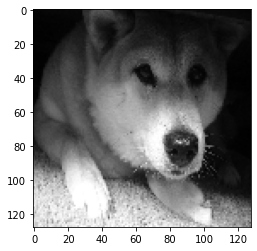

In [35]:
# img = cv2.imread(img_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(np.array(load_img(img_paths[preview_idx], target_size=img_size, color_mode="grayscale")), 2)
plt.imshow(img, cmap="gray")

# Helper functions

In [98]:
def map2bin(lab, fg_vals, bg_vals, fg=1, bg=0):
    fg_mask = np.isin(lab, fg_vals)
    bg_mask = np.isin(lab, bg_vals)
    lab_c = lab.copy()
    lab_c[fg_mask] = fg
    lab_c[bg_mask] = bg
    return lab_c


def augment(img, rot, hflip, vflip, expand_dims=True):
    og_shape = img.shape
    hw = img.shape[:2]
    # Horizontal flip
    if hflip:
        img = cv2.flip(img, 1)
    # Vertical flip
    if vflip:
        img = cv2.flip(img, 0)
    # Rotation
    rot_mat = cv2.getRotationMatrix2D((hw[1] // 2, hw[0] // 2), rot, 1.0)
    
    if expand_dims:
        img = np.expand_dims(cv2.warpAffine(img, rot_mat, hw), 2)
    
    return img

# Data pipeline

In [99]:
class OxfordPetsSequence(keras.utils.Sequence):
    """Helper to iterate over the data"""
    # TODO: edit to turn off augmentations for validation 
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, random_state, fg_vals, bg_vals, augmentation_function=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.rs: np.random.RandomState = random_state
        self.fg_vals = fg_vals
        self.bg_vals = bg_vals
        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        i = idx * self.batch_size 
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # Load the input images and convert them to grayscale
        def load_x():
            x = np.zeros((len(batch_input_img_paths),) + self.img_size + (1,), dtype=np.float32)
            for j, path in enumerate(batch_input_img_paths):
                img = load_img(path, target_size=self.img_size, color_mode="grayscale")
                img = np.expand_dims(img, 2) # add a third dimension to the array
                x[j] = img
            return x

        # load the target images and condense the number of labels in the segmentation mask
        def load_y():
            y = np.zeros((len(batch_target_img_paths),) + self.img_size + (1,), dtype=np.uint8)
            for j, path in enumerate(batch_target_img_paths):
                img = load_img(path, target_size=self.img_size, color_mode="grayscale")
                # add a third dimension to the array
                img = np.expand_dims(img, 2)
                # Collapse the mask from three labels to two labels
                img = map2bin(img, self.fg_vals, self.bg_vals)
                y[j] = img
            return y

        x, y = d.compute((d.delayed(load_x)(), d.delayed(load_y)()))[0]
        
        if self.augmentation_function != None:
            m = len(x)
            rots, hflips, vflips = d.compute([
                d.delayed(np.random.choice)([0, 90, 180, 270], size=m),
                d.delayed(np.random.choice)([True, False], size=m),
                d.delayed(np.random.choice)([True, False], size=m),
            ])[0]

            def aug_imgs(imgs):
                return np.array([self.augmentation_function(imgs[i], rots[i], hflips[i], vflips[i]) for i in range(m)])
            
            x, y = d.compute((d.delayed(aug_imgs)(x), d.delayed(aug_imgs)(y)))[0]

        return x, y

0.10198688507080078


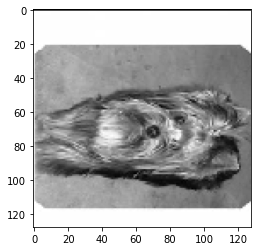

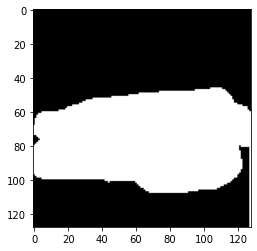

In [103]:
pets = OxfordPetsSequence(batch_size, img_size, img_paths, label_paths, rs, fg_vals, bg_vals, augment)
start = time.time()
X, y = pets[1]
stop = time.time()
print(stop - start)
plt.imshow(X[1][:,:,0], cmap='gray')
plt.show()
plt.imshow(y[1][:,:,0], cmap='gray')
plt.show()

In [48]:
def get_oxford_pets_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))
    
    ### Downsampling the inputs ###
    
    # compute an initial set of 32 features using convolutional layers 
    # also, downsample the image using strided convolutions
    x = layers.Conv2D(32, 3, strides = 2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    # hidden layers using Xception convolutions
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        
        previous_block_activation = x
        
    ### upsampling ###
    
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  
        previous_block_activation = x  
        
    # add a per-pixel classification layer 
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    # define the model 
    model = keras.Model(inputs, outputs)
    
    return model


In [50]:
### load the data ###
# shuffle the data
import random
num_val_samples = 1000
random.Random(0).shuffle(img_paths)
random.Random(0).shuffle(label_paths)
# splitting paths for training and validation
train_input_img_paths = img_paths[:-num_val_samples]
train_target_img_paths = label_paths[:-num_val_samples]
val_input_img_paths = img_paths[-num_val_samples:]
val_target_img_paths = label_paths[-num_val_samples:]
# create a data Sequence 
train_gen = OxfordPetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths, rs, fg_vals, bg_vals, augment)
val_gen = OxfordPetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths, rs, fg_vals, bg_vals, augment)

In [51]:
### create the model ###
keras.backend.clear_session()
model = get_oxford_pets_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [52]:
# tell tf to use the gpu
import tensorflow as tf
tf.device(tf.test.gpu_device_name())

In [53]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [54]:
### train the model ###
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation_2classes_augmentations.h5", save_best_only=True)]
num_epochs = 3
model.fit(train_gen, validation_data=val_gen, epochs=num_epochs, callbacks=callbacks)

Epoch 1/3
199/199 [==============================] - 34s 137ms/step - loss: 0.7974 - val_loss: 2.4113
Epoch 2/3
199/199 [==============================] - 27s 135ms/step - loss: 0.4176 - val_loss: 1.9936
Epoch 3/3
199/199 [==============================] - 27s 135ms/step - loss: 0.3623 - val_loss: 0.3883


In [ ]:
# Generate predictions for all images in the validation set
val_gen = OxfordPetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

In [ ]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #`i`
v_idx = 600

# Display input image
display(Image(filename=val_input_img_paths[v_idx]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[v_idx]))
display(img)

# Display mask predicted by our model
display_mask(v_idx)  # Note that the model only sees inputs at 150x150.